Data: 1000 restaurants for each city

1. Cuisines: most popular (bar chart)
2. Chains: Rating and # franchinese (bokeh)
3. Distributions of features
    * 2D distributions of features
4. Cuisines: price vs rating (bokeh... see next notebook)

TODO
* Scatter plot: average rating and cost for each cuisine, cuisine at least N samples
* Which cities have the greatest concentration of mexican, ethiopian, etc.
* Determine restaurants with single category and then look for relationships between category and price, rating, review count, etc.
* Explore data using a bokeh plot in http://localhost:8889/notebooks/examples/app/movies/Untitled.ipynb
    * This is a plot could have on my webpage (not a dashboard) !!
* What are the most popular and least popular?
* Which cities are nicest, best restaurants? (may be sampling bias. maybe should use sort by alphabet?)
* Which cities are cheapest?
* plot poke on maps

Notes
* Per capita analysis may not be valid because yelp searches around a city, not just where the population was counted
    * e.g. South San Francisco search on Yelp likely brings up restaurants outside the range of population counted
    * This could be assuaged if I instead delineate restaurants by the city their address says
* Categories - might be overlapping
    * I should look through top 100 and manually collapse some (deli and sanwich; japanese and sushi). One is a subset of another
* BOkeh sometimes stops working in its exported html when make multiple in 1 notebook

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os
import scipy as sp
from scipy import stats

from tools.plt import color2d #from the 'srcole/tools' repo
from matplotlib import cm

### Load dataframes

In [2]:
# Load cities info
df_cities = pd.read_csv('/gh/data2/yelp/city_pop.csv', index_col=0)
df_cities.head()

city       state  population  total_food   latitude   longitude  \
0     New York    New York     8537673       54191  40.705445  -73.994293   
1  Los Angeles  California     3976322       41685  34.061590 -118.321381   
2      Chicago    Illinois     2704958       19315  41.905159  -87.677765   
3      Houston       Texas     2303482       15197  29.784854  -95.359955   
4      Phoenix     Arizona     1615017       11034  33.465086 -112.070160   

   total_scraped  
0           1000  
1           1000  
2           1000  
3           1000  
4           1000

In [3]:
# Load restaurants
df_restaurants = pd.read_csv('/gh/data2/yelp/food_by_city/df_restaurants.csv', index_col=0)
df_restaurants.head()

id                     name      city  \
0          poquito-picante-brooklyn-2          Poquito Picante  New York   
1                  nourish-brooklyn-4                  Nourish  New York   
2            taste-of-heaven-brooklyn          Taste of Heaven  New York   
3  milk-and-cream-cereal-bar-new-york  Milk & Cream Cereal Bar  New York   
4           the-bao-shoppe-new-york-2           The Bao Shoppe  New York   

      state  rating  review_count  cost   latitude  longitude  has_delivery  \
0  New York     4.5            40     2  40.685742 -73.981262          True   
1  New York     4.0            65     2  40.677960 -73.968550          True   
2  New York     5.0            19     2  40.717150 -73.940540         False   
3  New York     4.5           307     2  40.719580 -73.996540         False   
4  New York     4.0            99     1  40.714345 -73.990518         False   

   has_pickup                                                url  
0        True  https://www.yelp.com/biz/poquito-picante-brook...  
1        True  https://www.yelp.com/biz/nourish-brooklyn-4?ad...  
2        True  https://www.yelp.com/biz/taste-of-heaven-brook...  
3       False  https://www.yelp.com/biz/milk-and-cream-cereal...  
4       False  https://www.yelp.com/biz/the-bao-shoppe-new-yo...

In [9]:
# Load categories by restaurant
df_categories = pd.read_csv('/gh/data2/yelp/food_by_city/df_categories.csv', index_col=0)
df_categories.head()

acaibowls  accessories  active  acupuncture  adultedu  advertising  \
0          0            0       0            0         0            0   
1          0            0       0            0         0            0   
2          0            0       0            0         0            0   
3          0            0       0            0         0            0   
4          0            0       0            0         0            0   

   aerialfitness  afghani  african  airport_shuttles  ...   wine_bars  \
0              0        0        0                 0  ...           0   
1              0        0        0                 0  ...           0   
2              0        0        0                 0  ...           0   
3              0        0        0                 0  ...           0   
4              0        0        0                 0  ...           0   

   wineries  winetasteclasses  winetastingroom  winetours  womenscloth  wraps  \
0         0                 0                0          0            0      0   
1         0                 0                0          0            0      0   
2         0                 0                0          0            0      0   
3         0                 0                0          0            0      0   
4         0                 0                0          0            0      0   

   yelpevents  yoga  zoos  
0           0     0     0  
1           0     0     0  
2           0     0     0  
3           0     0     0  
4           0     0     0  

[5 rows x 684 columns]

# 1. What are most popular categories?

In [10]:
# Manually concatenate categories with at least 500 counts
# Find categories D and V such that category 'D' should be counted as vategory 'V'
category_subsets = {'delis': 'sandwiches',
                    'sushi': 'japanese',
                    'icecream': 'desserts',
                    'cafes': 'coffee',
                    'sportsbars': 'bars',
                    'hotdog': 'hotdogs',
                    'wine_bars': 'bars',
                    'pubs': 'bars',
                    'cocktailbars': 'bars',
                    'beerbar': 'bars',
                    'tacos': 'mexican',
                    'gastropubs': 'bars',
                    'ramen': 'japanese',
                    'chocolate': 'desserts',
                    'dimsum': 'chinese',
                    'cantonese': 'chinese',
                    'szechuan': 'chinese',
                    'coffeeroasteries': 'coffee',
                    'hookah_bars': 'bars',
                    'irish_pubs': 'bars'}

for k in category_subsets.keys():
    df_categories[category_subsets[k]] = np.logical_or(df_categories[k], df_categories[category_subsets[k]])

In [11]:
# Remove some categories                                                                                       # R
category_remove = ['hotdog', 'cafes']
for k in category_remove:
    df_categories.drop(k, axis=1, inplace=True)

In [12]:
# Top categories
N = 20
category_counts = df_categories.sum().sort_values(ascending=False)
top_N_categories = list(category_counts.head(N).keys())
top_N_categories_counts = category_counts.head(N).values

category_counts.head(N)

sandwiches          73219.0
mexican             65826.0
hotdogs             63692.0
bars                55038.0
tradamerican        52656.0
pizza               50188.0
burgers             48277.0
coffee              42829.0
breakfast_brunch    39025.0
newamerican         31026.0
desserts            29916.0
chinese             28560.0
italian             28380.0
seafood             26280.0
japanese            24984.0
grocery             22727.0
salad               22291.0
bakeries            20171.0
foodtrucks          19650.0
chicken_wings       17667.0
dtype: float64

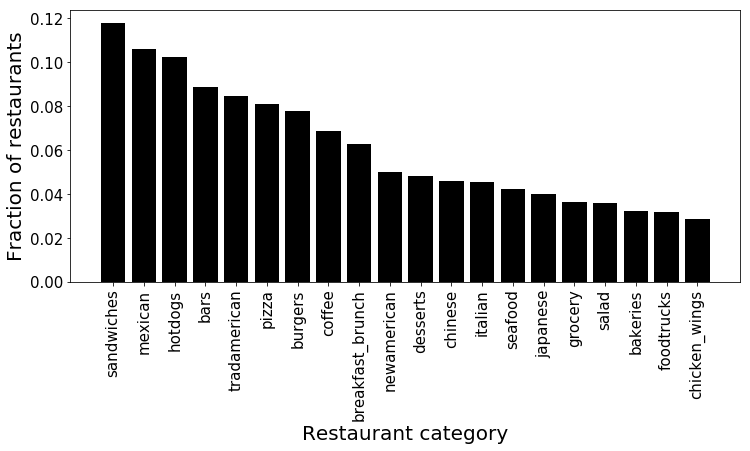

In [13]:
# Bar chart
plt.figure(figsize=(12,5))
plt.bar(np.arange(N), top_N_categories_counts / len(df_restaurants), color='k', ecolor='.5')
plt.xticks(np.arange(N), top_N_categories)
plt.ylabel('Fraction of restaurants', size=20)
plt.xlabel('Restaurant category', size=20)
plt.xticks(size=15, rotation='vertical')
plt.yticks(size=15);

# 2. What are the most common restaurant chains?

In [5]:
gb = df_restaurants.groupby('name')
df_chains = gb.mean()[['rating', 'review_count', 'cost']]
df_chains['count'] = gb.size()
df_chains.sort_values('count', ascending=False, inplace=True)
df_chains.head(10)

rating  review_count      cost  count
name                                                   
Subway          2.922554      5.474838  1.815844   8167
McDonald's      2.182025     12.400315  1.425018   5708
Starbucks       3.321750     23.568826  1.735268   4446
Taco Bell       2.620842     11.928064  1.300256   3517
Wendy's         2.492046      9.558568  1.435647   2766
Burger King     2.241244      7.554769  1.561103   2684
Dunkin' Donuts  2.719626      9.031598  1.387628   2247
Walgreens       2.964069      4.881941  1.994867   2143
Domino's Pizza  2.943810     13.044762  1.875714   2100
Pizza Hut       2.286355      9.845618  2.078187   2008

### 2a. Correlations in chain properties
* higher rating --> more reviews, fewer branches
* more branches --> fewer reviews
* 'u' relationship between cost and review count: lots of reviews to branches that are consistently 1, or consistently 2, but not those that are inconsistent
    * true for min_count = 40, 50, 100, 200, 

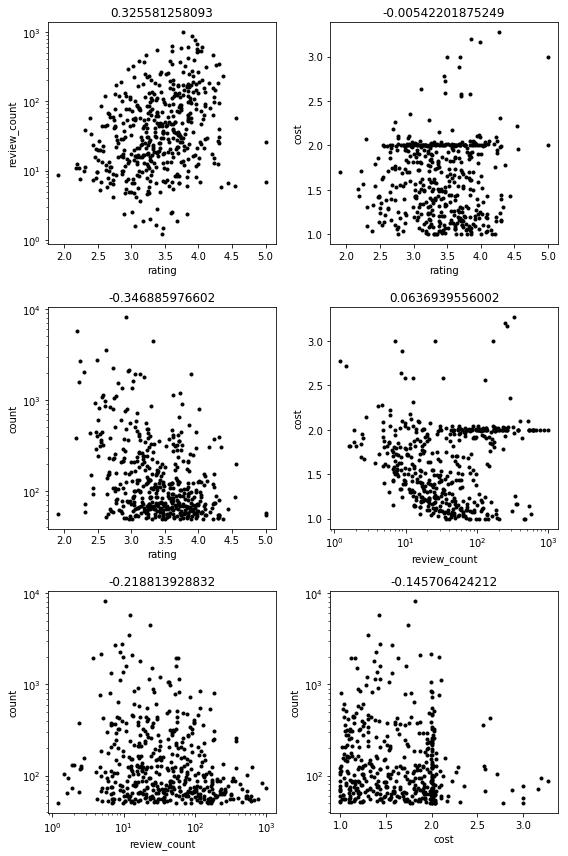

In [6]:
# Only consider restaurants with at least 50 locations
min_count = 50
df_temp = df_chains[df_chains['count'] >= min_count]

plt.figure(figsize=(8,12))
plt_num = 1
for i, k1 in enumerate(df_temp.keys()):
    for j, k2 in enumerate(df_temp.keys()[i+1:]):
        if k1 in ['review_count', 'count']:
            if k2 in ['review_count', 'count']:
                plot_f = plt.loglog
            else:
                plot_f = plt.semilogx
        else:
            if k2 in ['review_count', 'count']:
                plot_f = plt.semilogy
            else:
                plot_f = plt.plot
        plt.subplot(3, 2, plt_num)
        plot_f(df_temp[k1], df_temp[k2], 'k.')
        plt.xlabel(k1)
        plt.ylabel(k2)
        plt_num += 1
        r, p = stats.spearmanr(df_temp[k1], df_temp[k2])
        plt.title(r)
plt.tight_layout()

### 2b. Number of franchises vs rating (bokeh)

In [28]:
from bokeh.io import output_notebook
from bokeh.layouts import row, widgetbox
from bokeh.models import CustomJS, Slider, Legend, HoverTool
from bokeh.plotting import figure, output_file, show, ColumnDataSource

output_notebook()

# Slider variables
min_N_franchises = 100

# Determine dataframe sources
df_chains2 = df_chains[df_chains['count'] > 10].reset_index()
df_temp = df_chains2[df_chains2['count'] >= min_N_franchises]

# Create data source for plotting and Slider callback
source1 = ColumnDataSource(df_temp, id='source1')
source2 = ColumnDataSource(df_chains2, id='source2')

hover = HoverTool(tooltips=[
    ("Name", "@name"),
    ("Avg Stars", "@rating"),
    ("# locations", "@count")])

# Make initial figure of net income vs years of saving
plot = figure(plot_width=400, plot_height=400,
              x_axis_label='Number of locations',
              y_axis_label='Average rating',
              x_axis_type="log", tools=[hover])

plot.scatter('count', 'rating', source=source1, line_width=3, line_alpha=0.6, line_color='black')

# Declare how to update plot on slider change
callback = CustomJS(args=dict(s1=source1, s2=source2), code="""
    var d1 = s1.get("data");
    var d2 = s2.get("data");
    var N = N.value;
    d1["count"] = [];
    d1["rating"] = [];
    for(i=0;i <=d2["count"].length; i++){
        if (d2["count"][i] >= N) {
        d1["count"].push(d2["count"][i]);
        d1["rating"].push(d2["rating"][i]);
        d1["name"].push(d2["name"][i]);
        }
    }

    s1.change.emit();
""")

N_slider = Slider(start=10, end=1000, value=min_N_franchises, step=10,
                  title="minimum number of franchises", callback=callback)
callback.args["N"] = N_slider

# Define layout of plot and sliders
layout = row(plot, widgetbox(N_slider))

# Output and show
output_file("/gh/srcole.github.io/assets/misc/yelp_bokeh.html", title="Yelp WIP")
show(layout)

Loading BokehJS ...

E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name: cost, rating [renderer: GlyphRenderer(id='34516048-4a35-4a7c-b102-686c869fe5a4', ...)]


# 3. Distributions of ratings, review counts, and costs

### 3a. Distibutions

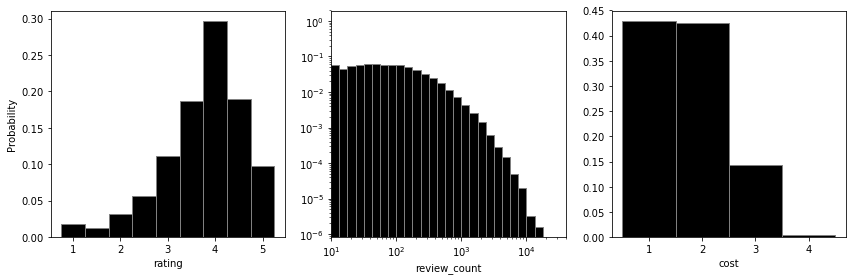

In [13]:
N_bins_per_factor10 = 8
bins_by_key = {'rating': np.arange(0.75, 5.75, .5),
               'review_count': np.logspace(1, 5, num=N_bins_per_factor10*4+1),
               'cost': np.arange(.5, 5, 1)}
log_by_key = {'rating': False,
               'review_count': True,
               'cost': False}

plt.figure(figsize=(12, 4))
for i, k in enumerate(bins_by_key.keys()):
    weights = np.ones_like(df_restaurants[k].values)/float(len(df_restaurants[k].values))
    plt.subplot(1, 3, i+1)
    plt.hist(df_restaurants[k].values, bins_by_key[k], log=log_by_key[k],
             color='k', edgecolor='.5', weights=weights)
    if k == 'review_count':
        plt.semilogx(1,1)
        plt.xlim((10, 40000))
    elif i == 0:
        plt.ylabel('Probability')
    plt.xlabel(k)
plt.tight_layout()

### 3b. Correlations (histograms)

In [14]:
# Prepare histogram analysis
gb_cost = df_restaurants.groupby('cost').groups
gb_rating = df_restaurants.groupby('rating').groups

# Remove 0 from gb_rating
gb_rating.pop(0.0)

N_bins_cost = len(gb_cost.keys())
N_bins_count = len(bins_by_key['review_count']) - 1
N_bins_rate = len(bins_by_key['rating']) - 1

# Hist: review count and rating as fn of cost
hist_count_by_cost = np.zeros((N_bins_cost, N_bins_count))
hist_rate_by_cost = np.zeros((N_bins_cost, N_bins_rate))
points_count_by_cost = np.zeros((N_bins_cost, 3))
points_rate_by_cost = np.zeros((N_bins_cost, 3))
for i, k in enumerate(gb_cost.keys()):
    # Make histogram of review count as fn of cost
    x = df_restaurants.loc[gb_cost[k]]['review_count'].values
    hist_temp, _ = np.histogram(x, bins=bins_by_key['review_count'])
    # Make each cost sum to 1
    hist_count_by_cost[i] = hist_temp / np.sum(hist_temp)
    # Compute percentiles
    points_count_by_cost[i,0] = np.mean(x)
    points_count_by_cost[i,1] = np.std(x)
    points_count_by_cost[i,2] = np.min([np.std(x), 5-np.mean(x)])
    
    # Repeat for rating
    x = df_restaurants.loc[gb_cost[k]]['rating'].values
    hist_temp, _ = np.histogram(x, bins=bins_by_key['rating'])
    hist_rate_by_cost[i] = hist_temp / np.sum(hist_temp)
    points_rate_by_cost[i,0] = np.mean(x)
    points_rate_by_cost[i,1] = np.std(x)
    points_rate_by_cost[i,2] = np.min([np.std(x), 5-np.mean(x)])
    
# Make histograms of review count as fn of rating
hist_count_by_rate = np.zeros((N_bins_rate, N_bins_count))
points_count_by_rate = np.zeros((N_bins_rate, 3))
for i, k in enumerate(gb_rating.keys()):
    # Make histogram of review count as fn of cost
    x = df_restaurants.loc[gb_rating[k]]['review_count'].values
    hist_temp, _ = np.histogram(x, bins=bins_by_key['review_count'])
    # Make each cost sum to 1
    hist_count_by_rate[i] = hist_temp / np.sum(hist_temp)
    points_count_by_rate[i,0] = np.mean(x)
    points_count_by_rate[i,1] = np.std(x)
    points_count_by_rate[i,2] = np.min([np.std(x), 5-np.mean(x)])

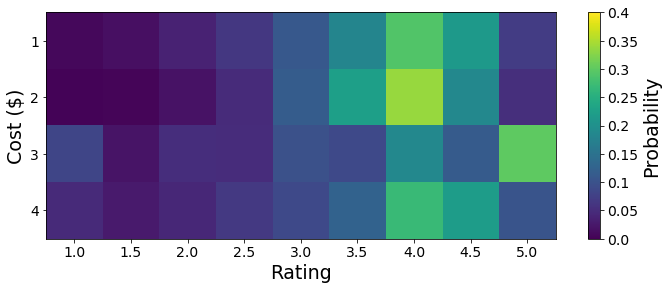

In [15]:
# Make a 2d colorplot
plt.figure(figsize=(10,4))
color2d(hist_rate_by_cost, cmap=cm.viridis,
        clim=[0,.4], cticks = np.arange(0,.41,.05), color_label='Probability',
        plot_xlabel='Rating', plot_ylabel='Cost ($)',
        plot_xticks_locs=range(N_bins_rate), plot_xticks_labels=gb_rating.keys(),
        plot_yticks_locs=range(N_bins_cost), plot_yticks_labels=gb_cost.keys(),
        interpolation='none', fontsize_minor=14, fontsize_major=19)

# On top, plot the mean and st. dev.
# plt.errorbar(points_rate_by_cost[:,0] / , np.arange(N_bins_cost), fmt='.', color='w', ms=10,
#              xerr=points_rate_by_cost[:,1:].T, ecolor='w', alpha=.5)

(-0.5, 16.5)

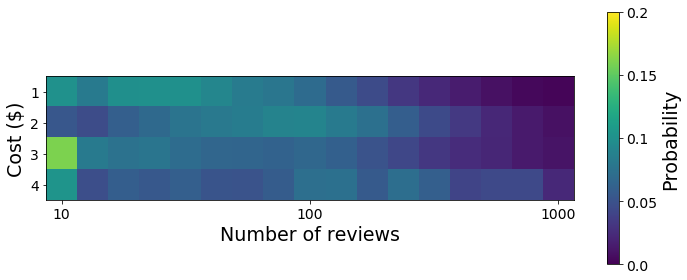

In [16]:
# Make a 2d colorplot
xbins_label = np.arange(0,N_bins_per_factor10*2+1, N_bins_per_factor10)
plt.figure(figsize=(10,4))
color2d(hist_count_by_cost, cmap=cm.viridis,
        clim=[0,.2], cticks = np.arange(0,.21,.05), color_label='Probability',
        plot_xlabel='Number of reviews', plot_ylabel='Cost ($)',
        plot_xticks_locs=xbins_label, plot_xticks_labels=bins_by_key['review_count'][xbins_label].astype(int),
        plot_yticks_locs=range(N_bins_cost), plot_yticks_labels=gb_cost.keys(),
        interpolation='none', fontsize_minor=14, fontsize_major=19)
plt.xlim((-.5,N_bins_per_factor10*2 + .5))

(-0.5, 16.5)

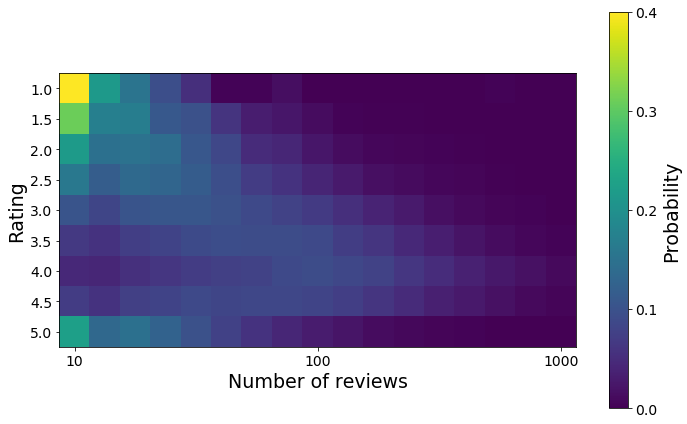

In [17]:
# Make a 2d colorplot
xbins_label = np.arange(0,N_bins_per_factor10*2+1, N_bins_per_factor10)
plt.figure(figsize=(10,6))
color2d(hist_count_by_rate, cmap=cm.viridis,
        clim=[0,.4], cticks = np.arange(0,.41,.1), color_label='Probability',
        plot_xlabel='Number of reviews', plot_ylabel='Rating',
        plot_xticks_locs=xbins_label, plot_xticks_labels=bins_by_key['review_count'][xbins_label].astype(int),
        plot_yticks_locs=range(N_bins_rate), plot_yticks_labels=gb_rating.keys(),
        interpolation='none', fontsize_minor=14, fontsize_major=19)
plt.xlim((-.5,N_bins_per_factor10*2 + .5))